In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nlpde_bifurcations as nlpb
import nlpde_utils

import dill
import datetime

# Explanation

In this notebook, we show how to use the bifurcation classes that are in the 'nlpde_bifurcations' module.
Computing a whole bifurcation diagram requires some manual interventions and is hard to completely automate, one needs to determine initial points on branches, make sure the solver converges, etc.

The bifurcation diagrams shown in the paper have been precomputed and saved into .pkl files, which can be loaded using the dill package. There is a separate notebook just to open, visualize and explore the diagrams. 

## Numerical details

Essentially, a branch of the steady-state bifurcation diagram contains as function of a parameter $\lambda$, the solutions a system of equations
$$ F(X, \lambda) = 0,$$
which are --- starting from a suitable initial point $X$--- computed by varying $\lambda$ and solving this equation again, thereby tracking the solutions as function of $\lambda$. 

In our particular case, the algebraic equation is a discretizaton of the continuous equation for the steady states of the nonlocal PDE
$$ 0 = \partial_x\left(\partial_x \rho - \rho (1-\rho) \left[ \alpha \int_0^\ell \tilde g(x'-x) \rho(x') \text{d}x  + \beta B(x) \right]\right)$$
together with boundary conditions
$$ \partial_x \rho - \rho (1-\rho) \left[ \alpha \int_0^\ell \tilde g(x'-x) \rho(x') \text{d}x  + \beta B(x) \right]=0 \qquad x=0,x=\ell.$$
Here $B(x)$ indicates boundary influence, and we use, as explained in the text, the formulation
$$ B(x) = \int_{-\infty}^0 \tilde g(x'-x)\text{d}x + \int_\ell^\infty \tilde g(x'-x)\text{d}x,$$
with interpretation that there is an effect on particles in the domain of some outside material/medium, which has the same length scale and interaction kernel shape as the particle-particle interactions.

Note that in this case, 
$$ \begin{aligned}
\beta B(x) &= \alpha\rho_0 \left( \int_{-\infty}^0 \tilde g(x'-x)\text{d}x + \int_\ell^\infty \tilde g(x'-x)\text{d}x \right) \\
&= \alpha \rho_0 \left( \int_{-\infty}^\infty \tilde g(x'-x)\text{d}x - \int_0^\ell g(x'-x)\text{d}x \right) \\
&= -\alpha \rho_0 \int_{0}^\ell \tilde g(x'-x)\text{d}x .
\end{aligned}$$

This means that we can compute $B(x)$ directly if we have the discretization of the nonlocal operator. 

In the above, $\tilde g(x'-x)$ is a shortcut for $\text{sign}(x'-x) g(|x'-x|)$, and $g$ is the interaction kernel. 
The numerical bifurcation code works for any kernel, but in the paper we always use $g(x) = e^{-x}$. 

We use a discretization on Chebyshev interpolation points $x_j$, and approximate $u_j \approx \rho(x_j)$. The differentiation and nonlocal operator can be expressed as matrices operating on the vector $u$ (see the notebook on the eigenvalues and linear stability for more details). 

### Note on the length parameter

We rescale length with $\ell$, such that the functions are defined on $[0, 1]$. This means that instead of 
$$  0 = \partial_x\left(\partial_x \rho - \rho (1-\rho) \left[ \alpha \int_0^\ell \tilde g(x'-x) \rho(x') \text{d}x  + \beta B(x) \right]\right),$$ 
we solve (scale space $x \mapsto x/L$)
$$0 = \frac{1}{L} \partial_x\left( \frac{1}{L} \partial_x \rho - \rho (1-\rho) \left[ \alpha L \int_0^1 \tilde g(L(x'-x)) \rho(x') \text{d}x'  + \beta \hat B(x) \right]\right) $$
where 
$$ \hat B(x) = \int_{\mathbb{R}\backslash [0,1]} \tilde g(x'-x) \text{d}x $$

### Note on mass conservation

In finding the solutions, we need to enforce the conservation of mass
$$ \int_0^1 \rho(x) \text{d}x  = \rho_0$$.
We do this by introducing a dummy parameter $c$, and instead of solving the original equation
$$ 0 = \partial_x \left( \cdots \right) $$
we solve 
$$ 0 = \partial_x \left( \cdots \right) + c,$$
and add as extra equation the mass conservation (discretized version, using Clenshaw-Curtis integration)
$$  \int_0^1 \rho(x) \text{d}x  = \rho_0 $$

### Note on accuracy

We experienced that if $N$ is not large enough, the accuracy for large $\alpha$ or large $\ell$ goes down and the results are less reliable. For example unphysical solutions appear (with $\rho<0$). 
Moreover, this affects the stability calculations, if $N$ is not large, sometimes a branch will be indicated as stable (largest eigenvalue is zero), whereas when increasing $N$ the largest eigenvalue is seen to be positive. This happens because for larger $\alpha$ or $\ell$, the largest eigenvalue is actually very close to zero (but positive). Since we use a fixed threshold to determine whether this eigenvalue is positive/negative, it is sometimes inaccurate.
In the paper we used $N=300$ for the diagrams. 


**Each part of the notebook below is to be run on its own. Variable names are often the same, so it's best to restart the kernel, reload the packages above, and then run the cells corresponding to one type of bifurcation diagram**

-----------------
## 1D bifurcation diagram as function of $\alpha$

Note that we use neutral boundary conditions, i.e. $\beta = \alpha \rho_0$. So $\beta$ varies as $\alpha$ is varied. 

We need quite a high number of $N$ to reach the high $\alpha$ region (otherwise the algorithm produces unphysical solutions)

In [59]:
N=100 #### number of discretization points, we use N=300 for the paper

#### system parameters that are not changing
rho0=0.4
L=5


def g(x):
    # cell-cell interaction function
    return np.exp(-x)
def p(x):
    # packing function
    return 1.-x

#### spatial points and differentiation operator, rescale to [0,1]
D, x = nlpde_utils.cheb(N)
D *= 2
x = (x+1)/2

# matrix evaluating the nonlocal term, for fixed L (note that the L appears in the interaction function because we rescaled space)
A0 = nlpde_utils.get_A_cheb(x,lambda x: g(x*L),1, method='clencurt')

# integration weights
w,_ = nlpde_utils.clencurt(N)
w*=1/2

beta_factor = 1 ### can use this if we want to deviate from strictly neutral boundary interaction

def rhs(X, par):
    alpha, rho0, L = par
    # function values 
    u = X[:-1]
    c = X[-1] # dummy param for mass constraint
    flux = D@u - u*p(u)*L*(L*alpha*A0@u + (-1)*alpha*rho0*L*A0@np.ones_like(x)*beta_factor)
    res = np.zeros_like(X)
    res[:-1] = D@(flux) + c
    # impose BC and extra equation
    res[0] = flux[0]
    res[-2] = flux[-1]
    extra_eq = np.sum(w*u)-rho0
    res[-1] = extra_eq
    return res
def measure(X, pars):
    # The order parameter to compute
    u = X[:-1]
    return (w@((u-pars[1])**2 ))**0.5*(w@ ((.5*(x-1/2)+(x-1/2)**2)*(u-pars[1])))

def stab_matrices(X, pars):
    ### function returns matrices M and Q, will be used to solve for the eigenvalues using Mu = omega Qu (generalized eigenvalue problem)
    ### M is the linearization around the steady state
    alpha, rho0, L = pars
    u = X[:-1]
    M1 = D - alpha*L**2*(np.diag(u*p(u))@A0 + np.diag(1-2*u)@np.diag(A0@u - A0@np.ones_like(u)*rho0*beta_factor))
    M = D@M1
    M[0,:] = M1[0,:]
    M[-1,:]=M1[-1,:]
    BM = np.diag(np.ones(M1.shape[0]))
    BM[0,0] = 0
    BM[-1,-1]=0
    return M, BM

In [60]:
##### Collection of the branches
all_branches = []

### Initialization of a branch

We need to start from a 'guess' for a solution, from which we can start the continuation. We know that we are looking for profiles with bumps, so typically we use a cosine function (or a 'sharpened' version of the cosine) as initial guess. We then use the 'correct' function to obtain an actual solution of the steady state equation (correct essentially calls fsolve from scipy). 

This can be a bit of a trial-and-error process, so we make sure to plot and check the error of the initial solution.

Error: 7.040495123016246e-08, rho_0: 0.39999999999999997


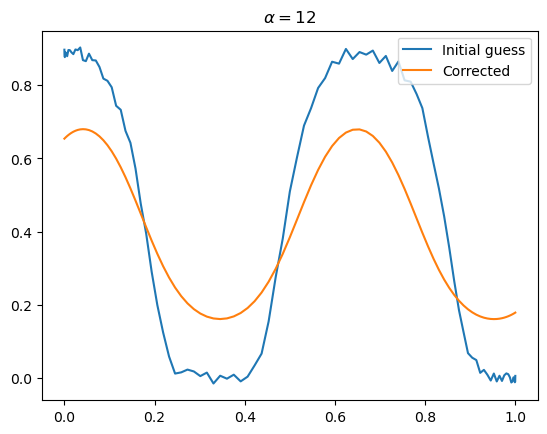

In [64]:
### start out
alpha = 12

u0 = (np.cos(3*np.pi*x)+1)/2
## sharpen the cosine a bit
def hill(x, n=3):
    return x**n/(.5**n+x**n)
u0 = hill(u0)
### add a bit of noise
u0 = u0 + np.random.normal(size=u0.shape)*0.01

stst0 = nlpb.SteadyState(rhs, np.hstack((u0,0)), [alpha, rho0,L], x=x)
stst0.correct()

#### make a plot
fig, ax = plt.subplots()
ax.plot(x, u0, label='Initial guess')
ax.plot(x, stst0.X[:-1], label='Corrected')
ax.set_title(r'$\alpha={}$'.format(alpha))
ax.legend()
####
#### Print the error and also the overall density to check if it really has converged and whether the mass is correct
print("Error: {}, rho_0: {}".format( np.max(stst0.rhs(stst0.X, stst0.pars)), w@stst0.X[:-1]))

In [65]:
### Continue the branch from this starting point
current_branch = len(all_branches) + 1

#### continue in two directions in one go
for direction in [1,-1]:
    startv = np.zeros(len(u0)+2)
    startv[-1]=direction

    ### setup the branch
    b = nlpb.Branch1Par(current_branch, 0, stst0, startv)

    ### adapt step size and min/max parameter
    b.h=2e-1
    b.par_max=16
    b.h_min = 2e-1
    b.h_max=0.1

    ### continue for given number of points
    b.continue_branch(200)

    ### compute measure (order parameter) and the stability of the points
    b.compute_measure(measure)
    b.compute_stability(stab_matrices, thr_zero=1e-5)
    
    all_branches.append(b)

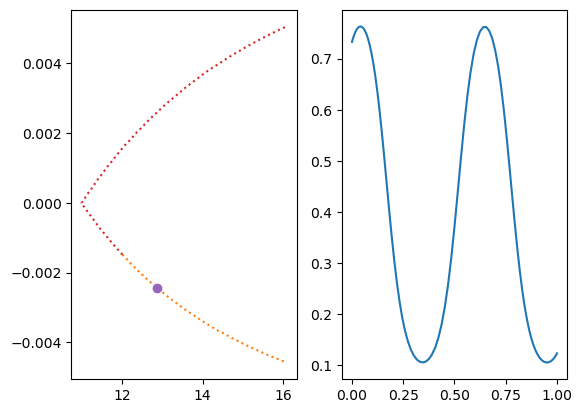

In [68]:
# plot the branches we have so far
## and point of choice
fig, axes = plt.subplots(1, 2)
for b in all_branches:
    pv = b.get_point_pars() # parameters
    muv = b.get_point_measures() # measure/order paramet
    stab = b.get_point_stability() # stability, is array of booleans

    ### plot the stable points
    axes[0].plot(pv[stab], muv[stab])
    ## unstable points
    axes[0].plot(pv[~stab], muv[~stab], ':')

### plot a point
branch_index = 0
point_index = 5
stst_to_plot = all_branches[branch_index].points[point_index]

axes[1].plot(stst_to_plot.x, stst_to_plot.X[:-1])
axes[0].plot(stst_to_plot.pars[0], stst_to_plot.mu, 'o')

-----------------
## 1D bifurcation diagram as function of $\ell$

A difference with alpha is that we need to recompute the matrix of the nonlocal operator for every different value of L. 
This means that this bifurcation diagram is much more computationally intensive than the one for alpha (or beta, below). 

In [69]:
N=100 #### number of discretization points, we use N=300 for the paper

#### system parameters that are not changing
rho0=0.4
alpha=15

def g(x):
    # cell-cell interaction function
    return np.exp(-x)
def p(x):
    # packing function
    return 1.-x

#### spatial points and differentiation operator, rescale to [0,1]
D, x = nlpde_utils.cheb(N)
D *= 2
x = (x+1)/2

def rhs(X, par):
    alpha, rho0, L = par
    # function values 
    u = X[:-1]
    c = X[-1] # dummy param for mass constraint

    ############ We need to compute matrix A
    A0 = nlpde_utils.get_A_cheb(x,lambda x: g(x*L),1, method='clencurt')
   
    flux = D@u - u*p(u)*L*(L*alpha*A0@u + (-1)*alpha*rho0*L*A0@np.ones_like(x))
    res = np.zeros_like(X)
    res[:-1] = D@(flux) + c
    # impose BC and extra equation
    res[0] = flux[0]
    res[-2] = flux[-1]
    extra_eq = np.sum(w*u)-rho0
    res[-1] = extra_eq
    return res
def measure(X, pars):
    # The order parameter to compute
    u = X[:-1]
    return (w@((u-pars[1])**2 ))**0.5*(w@ ((.5*(x-1/2)+(x-1/2)**2)*(u-pars[1])))

def stab_matrices(X, pars):
    ### function returns matrices M and Q, will be used to solve for the eigenvalues using Mu = omega Qu (generalized eigenvalue problem)
    ### M is the linearization around the steady state
    alpha, rho0, L = pars
    u = X[:-1]
    A0 = nlpde_utils.get_A_cheb(x,lambda x: g(x*L),1, method='clencurt')

    M1 = D - alpha*L**2*(np.diag(u*p(u))@A0 + np.diag(1-2*u)@np.diag(A0@u - A0@np.ones_like(u)*rho0))
    M = D@M1
    M[0,:] = M1[0,:]
    M[-1,:]=M1[-1,:]
    BM = np.diag(np.ones(M1.shape[0]))
    BM[0,0] = 0
    BM[-1,-1]=0
    return M, BM

In [73]:
##### Collection of the branches
all_branches = []

Error: 1.2246124645695079e-06, rho_0: 0.4000000000000001


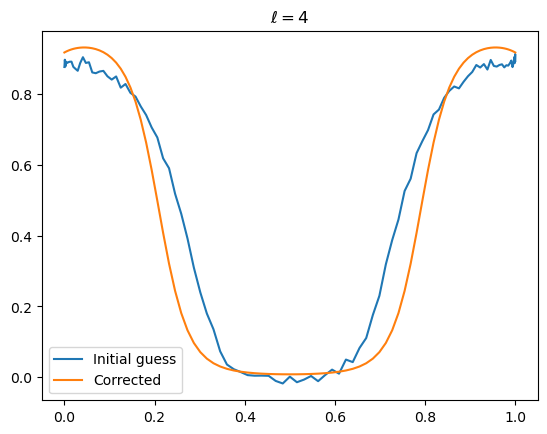

In [74]:
### start out
L = 4

u0 = (np.cos(2*np.pi*x)+1)/2
## sharpen the cosine a bit
def hill(x, n=3):
    return x**n/(.5**n+x**n)
u0 = hill(u0)
### add a bit of noise
u0 = u0 + np.random.normal(size=u0.shape)*0.01

stst0 = nlpb.SteadyState(rhs, np.hstack((u0,0)), [alpha, rho0,L], x=x)
stst0.correct()

#### make a plot
fig, ax = plt.subplots()
ax.plot(x, u0, label='Initial guess')
ax.plot(x, stst0.X[:-1], label='Corrected')
ax.set_title(r'$\ell={}$'.format(L))
ax.legend()
####
#### Print the error and also the overall density to check if it really has converged and whether the mass is correct
print("Error: {}, rho_0: {}".format( np.max(stst0.rhs(stst0.X, stst0.pars)), w@stst0.X[:-1]))

In [75]:
### Continue the branch from this starting point
current_branch = len(all_branches) + 1

#### continue in two directions in one go
for direction in [1,-1]:
    startv = np.zeros(len(u0)+2)
    startv[-1]=direction

    ### setup the branch. Note the '2' as second argument, this indicates that the varying parameter 
    ### on the branch is the one with index 2 in stst.pars
    b = nlpb.Branch1Par(current_branch, 2, stst0, startv)

    ### adapt step size and min/max parameter
    b.h=2e-1
    b.par_max=10
    b.h_min = 2e-1
    b.h_max=0.1

    ### continue for given number of points
    b.continue_branch(200)

    ### compute measure (order parameter) and the stability of the points
    b.compute_measure(measure)
    b.compute_stability(stab_matrices, thr_zero=1e-5)
    
    all_branches.append(b)

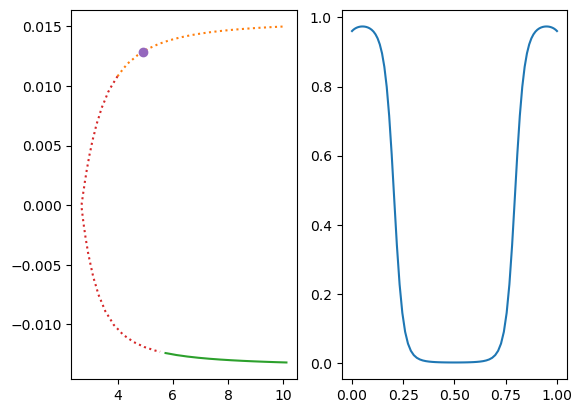

In [77]:
# plot the branches we have so far
## and a point of choice
fig, axes = plt.subplots(1, 2)
for b in all_branches:
    pv = b.get_point_pars() # parameters
    muv = b.get_point_measures() # measure/order parameter
    stab = b.get_point_stability() # stability, is array of booleans

    ### plot the stable points
    axes[0].plot(pv[stab], muv[stab])
    ## unstable points
    axes[0].plot(pv[~stab], muv[~stab], ':')

### plot a point
branch_index = 0
point_index = 5
stst_to_plot = all_branches[branch_index].points[point_index]

axes[1].plot(stst_to_plot.x, stst_to_plot.X[:-1])
axes[0].plot(stst_to_plot.pars[2], stst_to_plot.mu, 'o')

## 1D bifurcation diagram as function of $\beta$

No longer neutral boundary conditions. Otherwise everything is similar to the calculation of the alpha diagram.

In [42]:
N=200 #### number of discretization points, we use N=300 for the paper

#### system parameters that are not changing
alpha=15
rho0=0.4
L=5

### we can bias the boundary interaction to left/right by changing gamma
gamma=0

def g(x):
    # cell-cell interaction function
    return np.exp(-x)
def p(x):
    # packing function
    return 1.-x

#### spatial points and differentiation operator, rescale to [0,1]
D, x = nlpde_utils.cheb(N)
D *= 2
x = (x+1)/2

# matrix evaluating the nonlocal term, for fixed L (note that the L appears in the interaction function because we rescaled space)
A0 = nlpde_utils.get_A_cheb(x,lambda x: g(x*L),1, method='clencurt')

#### for the boundary (this is in case we want to change the kernel for the boundary, for now it's the same as A0)
A0b = nlpde_utils.get_A_cheb(x,lambda x: g(x*L),1, method='clencurt')

# integration weights
w,_ = nlpde_utils.clencurt(N)
w*=1/2

def rhs(X, par):
    beta, alpha, rho0, L = par
    c = X[-1]
    u = X[:-1]
    Bx = -beta*L*A0b@np.ones_like(x)*(1+gamma*(x-L/2)/L)
    res = np.zeros_like(X)
        
    flux = D@u - u*p(u)*L*(L*alpha*A0@u +Bx)
    res[:-1] = D@(flux) + c
    res[0] = flux[0] #BC
    res[-2] = flux[-1] # BC
    extra_eq = np.sum(w*u)-rho0
    res[-1] = extra_eq
    return res

def stab_matrices(X, pars):
    beta, alpha, rho0, L= pars
    u = X[:-1]
    Bx = - beta*L*A0b@np.ones_like(x)*(1+gamma*x/L)

    M1 = D +L*(-np.diag(u*p(u))@(alpha*L*A0) - np.diag(1-2*u)*(alpha*L*np.diag(A0@u) + np.diag(Bx)))
    M = D@M1
    M[0,:] = M1[0,:]
    M[-1,:]=M1[-1,:]
    BM = np.diag(np.ones(M1.shape[0]))
    BM[0,0] = 0
    BM[-1,-1]=0
    return M, BM
    
def measure(X, pars):
    # The order parameter to compute
    u = X[:-1]
    return (w@((u-pars[1])**2 ))**0.5*(w@ ((.5*(x-1/2)+(x-1/2)**2)*(u-pars[1])))

In [43]:
all_branches = []

Error: 4.69238820728235e-07, rho_0: 0.400000000000002


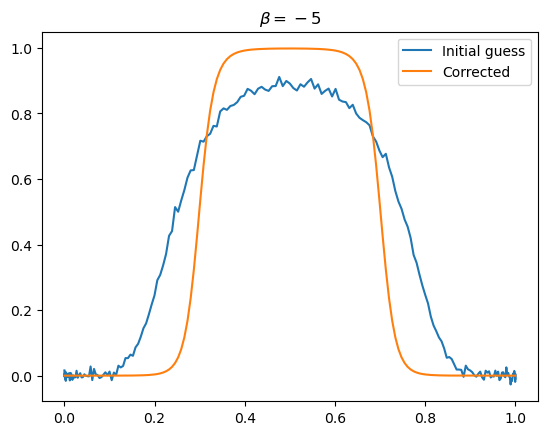

In [44]:
### start out
beta = -5

u0 = (-np.cos(2*np.pi*x)+1)/2
## sharpen the cosine a bit
def hill(x, n=3):
    return x**n/(.5**n+x**n)
u0 = hill(u0)
### add a bit of noise
u0 = u0 + np.random.normal(size=u0.shape)*0.01

stst0 = nlpb.SteadyState(rhs, np.hstack((u0,0)), [beta, alpha, rho0,L], x=x)
stst0.correct()

#### make a plot
fig, ax = plt.subplots()
ax.plot(x, u0, label='Initial guess')
ax.plot(x, stst0.X[:-1], label='Corrected')
ax.set_title(r'$\beta={}$'.format(beta))
ax.legend()
####
#### Print the error and also the overall density to check if it really has converged and whether the mass is correct
print("Error: {}, rho_0: {}".format( np.max(stst0.rhs(stst0.X, stst0.pars)), w@stst0.X[:-1]))

In [45]:
### Continue the branch from this starting point
current_branch = len(all_branches) + 1

#### continue 
for direction in [1]:
    startv = np.zeros(len(u0)+2)
    startv[-1]=direction

    ### setup the branch
    b = nlpb.Branch1Par(current_branch, 0, stst0, startv)

    ### adapt step size and min/max parameter
    b.h=2e-1
    b.par_max=20
    b.par_min=-10 # beta can be negative
    b.h_min = 2e-1
    b.h_max=0.1

    ### continue for given number of points
    b.continue_branch(400)

    ### compute measure (order parameter) and the stability of the points
    b.compute_measure(measure)
    b.compute_stability(stab_matrices, thr_zero=1e-5)
    
    all_branches.append(b)

In [46]:
all_branches

Text(0.5, 1.0, 'Largest eigenvalue: (-2.298870414338666e-09+0j)')

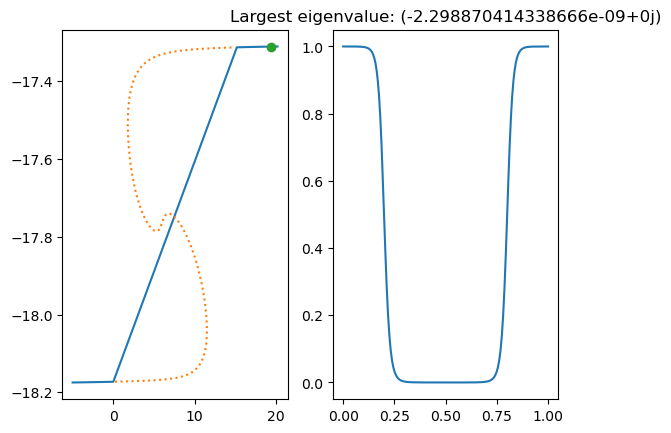

In [47]:
# plot the branches we have so far
## and a point of choice
fig, axes = plt.subplots(1, 2)
for b in all_branches:
    pv = b.get_point_pars() # parameters
    muv = b.get_point_measures() # measure/order parameter
    stab = b.get_point_stability() # stability, is array of booleans

    ### plot the stable points
    axes[0].plot(pv[stab], muv[stab])
    ## unstable points
    axes[0].plot(pv[~stab], muv[~stab], ':')

### plot a point
branch_index = 0
point_index = -5
stst_to_plot = all_branches[branch_index].points[point_index]

axes[1].plot(stst_to_plot.x, stst_to_plot.X[:-1])
axes[0].plot(stst_to_plot.pars[0], stst_to_plot.mu, 'o')
axes[1].set_title("Largest eigenvalue: {}".format(stst_to_plot.eigenvalues[0]))

-------------------
## 2D bifurcation diagram as function of $\beta$ and $\alpha$

The 2-parameter bifurcation diagram is more tricky, since we need to enforce more equations: we continue a special point (the bifurcation point). We use the method from Seydel (2010, section 5.9)

In particular, we require that the point $(X, \alpha, \beta)$, where $X$ consists of the $u_j$ and $c$ (dummy parameter for mass conservation), solves $F(X, \alpha, \beta) = 0$ (it has to be a steady state), but also that the Jacobian has a zero eigenvalue. Let $h$ be a vector of size $N+2$, and define $Y = (X, \alpha, \beta, h)$ (this has $N+2+2+N+2 = 2N+6$ components). We then require that $Y$ solves

$$ \begin{pmatrix}
F(X, \alpha, \beta) \\ DF(X, \alpha, \beta) h \\  ||h||_2 \end{pmatrix} = 0
$$

The second part says that $h$ is an eigenvector with eigenvalue $0$ of $DF$. The last equation is to fix the norm of $h$. In total, this gives $N+2 + N+2+1 = 2N+5$ equations. This equation can then be used to trace the curve in the $(\alpha, \beta)$ plane. 

**There may be a better extended system to use.**  The reason is that because of mass conservation, there is, for any steady state (not just bifurcation points), a zero eigenvalue and corresponding eigenvector, but only of the part of $DF$ without last row and column (that part corresponds to the nonlocal steady state PDE without the mass conservation requirement). The final row of $DF$ comes from the mass conservation equation. We found that the zero eigenvector that is `always there' has even symmetry, and it will not satisfy the final equation of $DF h = 0$, whereas for bifurcation points there is also an odd eigenvector with eigenvalue zero, which is the one we will start the continuation from. So it works, but there is probably a better way to do this.

#### Notes
- We noticed that everything worked better if we divide the steady state equation by $\alpha$.
- Some trial and error is required, as the branch-following algorithm was often found to 'turn back' and retrace a branch. This can be avoided by picking an endpoint, manually changing the parameter, correcting the point, and restarting the branch calculation in the right direction.
- An alternative method is to compute multiple 1-parameter bifurcation dioagrams in $\beta$, for increasing $\alpha$, and detect the instability points. Connecting these will give the boundary in the $(\beta, \alpha)$ plane.
- The numerical continuation method fails for large values of $\alpha$. This can be remedied by increasing $N$, at cost of increased computational time. In the figure in the paper, we show the numerically computed diagram up to $\alpha \approx 15$ and above that we show the approximations of the boundary, $\beta=0$ and $\beta=\alpha$. 

In [37]:
#### setup
N=100

def g(x):
    # cell-cell interaction function
    return np.exp(-x)

def p(x):
    # packing function
    return 1-x
D, x = nlpde_utils.cheb(N)
D *= 2
x = (x+1)/2

## parameters that are not changed
L=5
rho0=0.4

# matrix evaluating the nonlocal term
A0 = nlpde_utils.get_A_cheb(x,lambda x: g(x*L),1, method='clencurt')

# integration weights
w,_ = nlpde_utils.clencurt(N)
w*=1/2

# boundary interaction
A0b = nlpde_utils.get_A_cheb(x,lambda x: g(x*L),1, method='clencurt')

def rhs(X, par):
    beta, alpha, rho0, L = par
    c = X[-1]
    u = X[:-1]
    Bx = -beta*L*A0b@np.ones_like(x)
    res = np.zeros_like(X)
    #### note, divide by alpha -> this means the beta we compute later will actually be beta/alpha, so need to rescale later
    flux = D@u/alpha - u*p(u)*L*(L*1*A0@u +Bx)
    res[:-1] = D@(flux) + c
    res[0] = flux[0]
    res[-2] = flux[-1] # BC
    extra_eq = np.sum(w*u)-rho0
    res[-1] = extra_eq
    return res
def measure(X, pars):
    u = X[:-1]
    return np.sum(w*(u-pars[2])**2)**0.5 *np.sign(u[0]-pars[2])
def stab_matrices(X, pars):
    beta, alpha, rho0, L= pars
    u = X[:-1]
    Bx = - beta*L*A0b@np.ones_like(x)

    M1 = D/alpha +L*(-np.diag(u*p(u))@(1*L*A0) - np.diag(1-2*u)*(1*L*np.diag(A0@u) + np.diag(Bx)))
    M = D@M1
    M[0,:] = M1[0,:]
    M[-1,:]=M1[-1,:]
    BM = np.diag(np.ones(M1.shape[0]))
    BM[0,0] = 0
    BM[-1,-1]=0
    return M, BM

def DFX(X, pars):
    ### Jacobian of the system
    ### X is the one-par X consisting of u and c
    beta, alpha, rho0, L= pars

    DFX = np.zeros((N+2, N+2))

    u = X[:-1]
    Bx = - beta*L*A0b@np.ones_like(x)
    M1 = D/alpha +L*(-np.diag(u*p(u))@(1*L*A0) - np.diag(1-2*u)*(1*L*np.diag(A0@u) + np.diag(Bx)))
    M = D@M1
    M[0,:] = M1[0,:]
    M[-1,:]=M1[-1,:]
    
    # this goes into top left corner
    DFX[:-1,:-1] = M
    # bottom row: w from mass constraint
    DFX[-1, :-1] = w
    # right column: ones except for first and two last entries
    DFX[1:-2, -1]=1
    return DFX

################# RHS for the bifurcation points
def rhs_bp(X, pars):
    ### here X consists of u (N+1), c and h (N+2)
    beta, alpha, rho0, L= pars
    res = np.zeros(2*N+5)
    res[:N+2] = rhs(X[:N+2], pars)
    res[N+2:-1] = DFX(X[:N+2], pars)@X[N+2:]
    # last entry of res is a condition on h the eigenvector. Note last entry of X is not part of spatial eigenvector but is component related 
    #  to mass constraint
    res[-1] = np.sum(w*X[(N+2):-1]**2)-1
    return res
    

-----------
### Starting out

To start, we calculate part of the one-parameter bifurcation diagram in $\beta$, until we hit the bifurcation point.

Error: 4.225514482931351e-08, rho_0: 0.4000000000000001


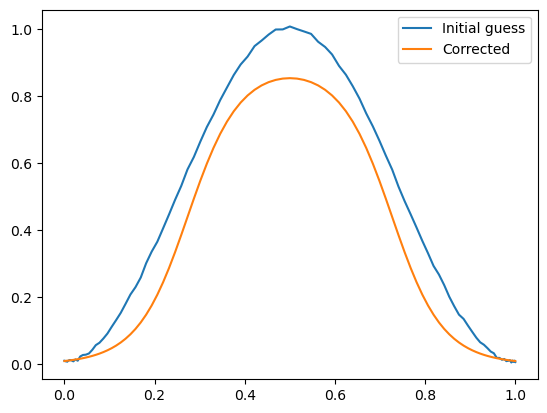

In [38]:
### start out with a continuation in only the parameter beta in order to detect the bifurcation point
alpha = 5
beta = -.5

##### initial guess (we start from beta smaller than zero, so middle bump)
u0 =(-np.cos(2*np.pi*x)*1+1)/2+ np.random.random(size=x.shape)*0.01

P0 = nlpb.SteadyState(rhs, np.hstack((u0,0)), [beta, alpha, rho0,L], x=x) 
P0.correct()

#### make a plot
fig, ax = plt.subplots()
ax.plot(x, u0, label='Initial guess')
ax.plot(x, P0.X[:-1], label='Corrected')
ax.legend()
####
#### Print the error and also the overall density to check if it really has converged and whether the mass is correct
print("Error: {}, rho_0: {}".format( np.max(P0.rhs(P0.X, P0.pars)), w@P0.X[:-1]))

In [39]:
### continuation in beta
startv = np.zeros(len(u0)+2)
startv[-1]=1 #### go to the right (in beta)

# branch
b = nlpb.Branch1Par(0, 0, P0, startv)
b.h=0.01
b.par_min=-10
b.par_max=15
b.h_min = 1e-2

b.continue_branch(300)

b.compute_measure(measure)
b.compute_stability(stab_matrices, thr_zero=1e-5)

Text(0.10157743366981048, -0.21567352960766, 'P1')

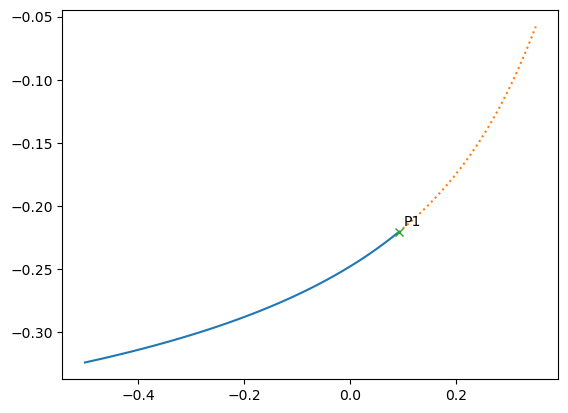

In [40]:
# plot the branch and indicate stability changes
fig, ax = plt.subplots()

pv = b.get_point_pars()
muv = b.get_point_measures()
stab = b.get_point_stability()

ax.plot(pv[stab], muv[stab])
ax.plot(pv[~stab], muv[~stab], ':')

# detect bifurcation point where st state becomes unstable
i=0
while b.points[i].stable:
    i+=1
P1 = b.points[i]

ax.plot(P1.pars[0], P1.mu, 'x')
ax.text(P1.pars[0]+0.01, P1.mu+0.005, 'P1')

### Set up the 2 parameter bifurcation branch

Idea is very similar to one-parameter branch, we now just have an extended set of equations (the rhs argument), and we have two parameters that can vary.

In [41]:
### clean list containing branches
branches_2p = []

[0.09157743 5.         0.4        5.        ] [0.09148729 5.         0.4        5.        ] 7.229391485452652e-08


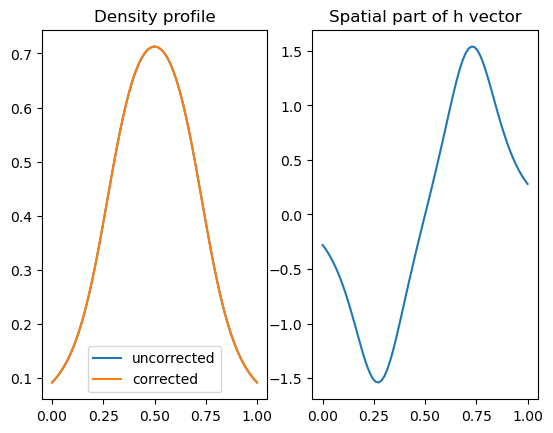

In [42]:
# vector h, initial guess
M = DFX(P1.X, P1.pars)
# force one component of h to be one for initial solve because we need an extra equation
## it is arbitrary which component we use for this.
k= int((1-rho0)/2*N)
M[k,:]=0
M[k,k]=1
r = np.zeros(M.shape[0])
r[k] = 1
h0 = np.linalg.solve(M, r)
# now normalize
#h0[:-1] /= np.sum(w*h0[:-1]**2)

######### create a new point 
bp0 = nlpb.BifurcationPoint(rhs_bp, np.hstack((P1.X, h0)), P1.pars.copy(), P1.x.copy())

# correct the point. We can choose which parameter to adapt (argumentt ot the correct function is index of parameter)
#### we correct while changing  beta

bp0.correct(0)
fig,axes = plt.subplots(1,2)
axes[0].plot(P1.x, P1.X[:N+1], label='uncorrected')
axes[0].plot(bp0.x, bp0.X[:N+1], label='corrected')
axes[0].set_title("Density profile")
axes[0].legend()
### the h vector
axes[1].plot(bp0.x, bp0.X[N+2:-1])
axes[1].set_title("Spatial part of h vector")

### print out parameters and error
print(P1.pars,bp0.pars, np.max(rhs_bp(bp0.X, bp0.pars)))

In [47]:
# set up the new branch (2 parameter)
current_branch = len(branches_2p) # name

start_v = np.zeros(len(bp0.X)+2) ## tangent vector
start_v[-2:] = np.array([.0, .15]) ## starting directino in beta, alpha

## setup branch. second argument is iterable of the indices of parameters that vary, here 0 for beta, 1 for alpha
b2 = nlpb.Branch2Par(current_branch, np.array([0,1]), bp0, start_v)

### bounds
b2.par_min = np.array([-10, 0])
b2.par_max = np.array([30, 30])

### step sizes
b2.h=.1
b2.h_min=.1


In [48]:
### continuation

b2.continue_branch(50)
branches_2p.append(b2)

Text(0.5, 1.0, 'norm h: 1.0000000002603784')

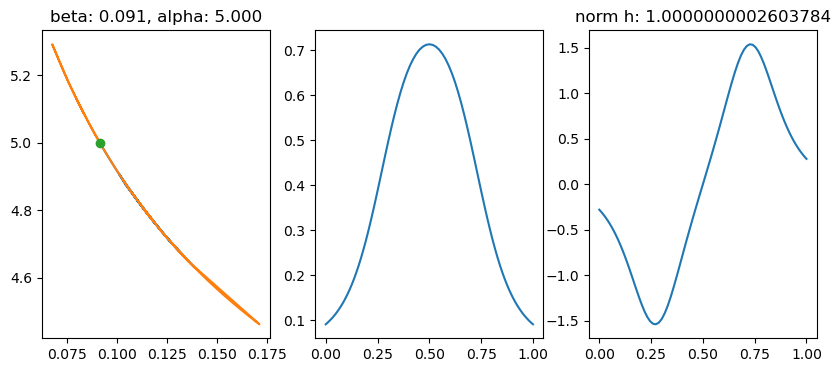

In [49]:
# plot the branches we have so far
## and a point of choice
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for b in branches_2p:
    pv1, pv2 = b.get_point_pars() # parameters
    ##### IMPORTANT
    ## since we rescaled with alpha, parameter 1 (beta) shouuld be multiplied by parameter 2 (alpha) to 
    ### get axis like the one in the papre
    #pv1 *= pv2
   
    axes[0].plot(pv1, pv2)
    
### plot a point of choice
branch_index = 0
point_index = 0
stst_to_plot = branches_2p[branch_index].points[point_index]

axes[1].plot(stst_to_plot.x, stst_to_plot.X[:N+1])
axes[0].plot(stst_to_plot.pars[0], stst_to_plot.pars[1], 'o')
axes[0].set_title('beta: {:.3f}, alpha: {:.3f}'.format(*stst_to_plot.pars[b.par_index]))
 # draw h or at least the spatial part
axes[2].plot(stst_to_plot.x, stst_to_plot.X[N+2:-1])
axes[2].set_title('norm h: {}'.format(w @ stst_to_plot.X[N+2:-1]**2))
   

In [36]:
b.par_index

array([0, 1])